In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedKFold, train_test_split

In [2]:
df_train=pd.read_csv("../../ravdess_features_train_pulito.csv")
df_test=pd.read_csv("../../ravdess_features_test_pulito.csv")

In [3]:
df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])

In [4]:
#df_train.drop(axis="index", labels=[35,243,451,554,563,658,659,1031,1075,1283], inplace=True)
X_train=df_train.drop(columns=["sum"]).values
y_train=df_train["sum"].values

#df_test.drop(axis="index", labels=[33,34,138,196,197,198,199], inplace=True)
X_test=df_test.drop(columns=["sum"]).values
y_test=df_test["sum"].values

In [5]:

#sel = SelectKBest(k=108)
#X_train = sel.fit_transform(X_train, y_train)
#X_test = sel.transform(X_test)


In [6]:
#scl = StandardScaler()
#X_train = scl.fit_transform(X_train)
#X_test = scl.transform(X_test)

# Random Forest

In [7]:
'''
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'criterion': ['squared_error', 'absolute_error'],
              'max_features': ["sqrt", "log2"],
              'n_estimators': [int(x) for x in np.linspace(100,1000,num=10)]
             }

grid_rdmforest = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                    param_distributions=param_list,
                    cv=RepeatedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=200)
grid_rdmforest.fit(X_train, y_train)
'''

'\nparam_list = {\'min_samples_split\': [2, 5, 10, 20],\n              \'min_samples_leaf\': [1, 5, 10, 20],\n              \'criterion\': [\'squared_error\', \'absolute_error\'],\n              \'max_features\': ["sqrt", "log2"],\n              \'n_estimators\': [int(x) for x in np.linspace(100,1000,num=10)]\n             }\n\ngrid_rdmforest = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),\n                    param_distributions=param_list,\n                    cv=RepeatedKFold(random_state=0, n_splits=3, n_repeats=5),\n                    n_jobs=-1,\n                    n_iter=200)\ngrid_rdmforest.fit(X_train, y_train)\n'

In [8]:
#grid_rdmforest.best_params_

Best params complete dataset (only OD): {'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'criterion': 'absolute_error'}

 Best params dataset con FS e OD: {'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'criterion': 'absolute_error'}

In [9]:
clf = RandomForestRegressor(n_estimators=600,min_samples_split=2,min_samples_leaf=1,max_features="sqrt",criterion="absolute_error", oob_score=True)
clf.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_features='sqrt',
                      n_estimators=600, oob_score=True)

In [10]:
y_pred = clf.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test,y_pred)}")
print(f"Mean absolute error: {mean_absolute_error(y_test,y_pred)}")
print(f"R2 score: {r2_score(y_test,y_pred)}")
print(f"Out of Bagging Error: {1-clf.oob_score_}")

Mean squared error: 0.9404835845639438
Mean absolute error: 0.39372485556154163
R2 score: 0.4231950539211451
Out of Bagging Error: 0.6582738161332405


### predicted vs residuals & predicted vs true

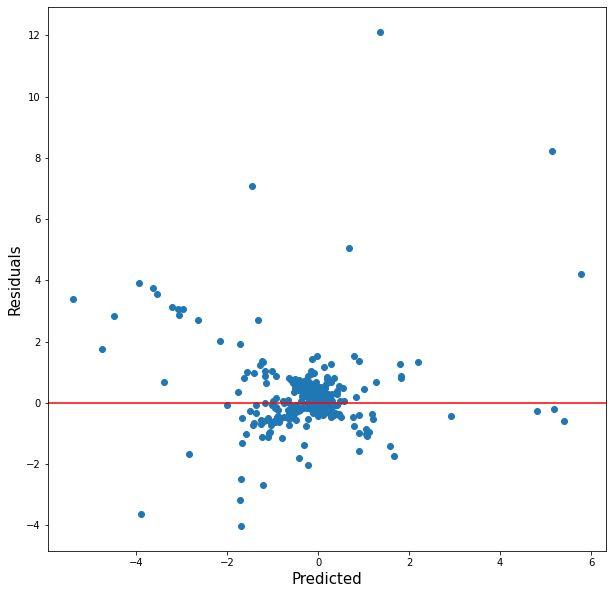

In [11]:
residuals = y_test-y_pred
plt.figure(figsize=(10,10))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.show()
# Se i punti sono scatterati attorno alla linea y=0 vuol dire che non ci sono errori sistematici (bias) nel modello

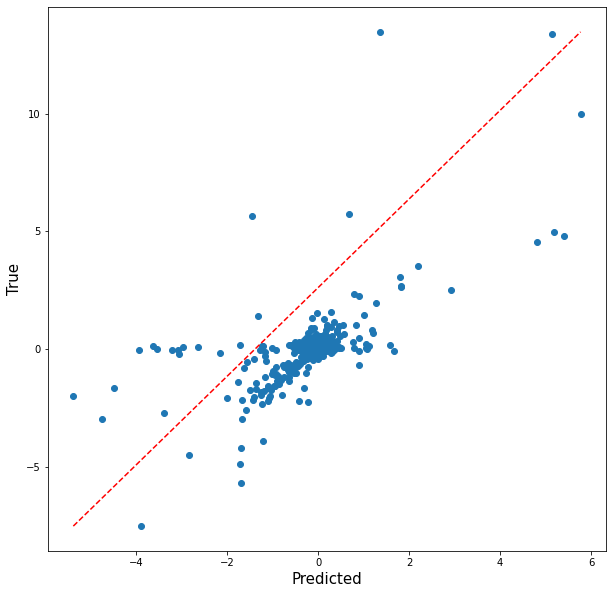

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(y_pred, y_test)
plt.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("True", fontsize=15)
plt.show()
# la linea diagonale corrisponderebbe a una perfetta predizione

### Features Importance

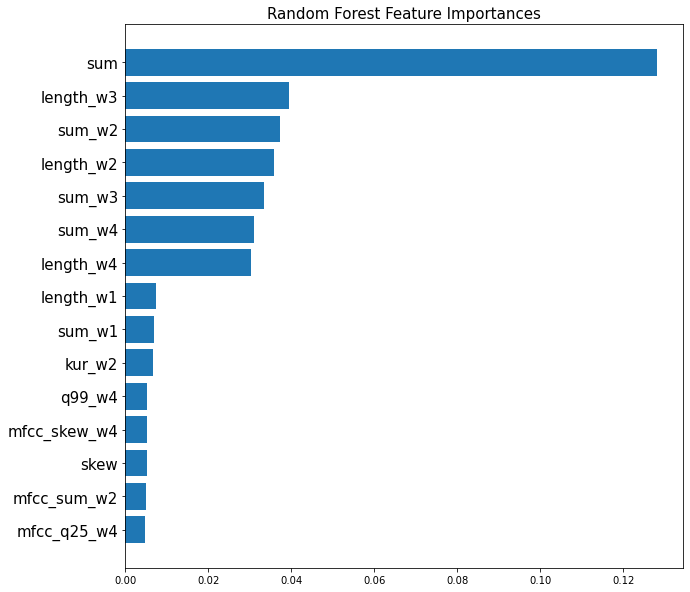

In [13]:
nbr_features = 15

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(squeeze=True, figsize=(10,10))
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(df_train.columns)[sorted_idx], fontsize=15)
plt.title("Random Forest Feature Importances", fontsize=15)
plt.show()

# XGBoost

In [14]:
XGBRegressor?

In [15]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=100)

In [16]:
'''
param_list = {
    'n_estimators': [100, 200, 400, 700],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.20],
    'sampling_method': ["uniform", "gradient_based"],
    'min_child_weight': [1, 10, 100]
    }

grid_rdmforest = RandomizedSearchCV(XGBRegressor(n_jobs=-1),
                    param_distributions=param_list,
                    cv=RepeatedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=200)
grid_rdmforest.fit(X_train, y_train)
'''

'\nparam_list = {\n    \'n_estimators\': [100, 200, 400, 700],\n    \'max_depth\': [2, 4, 6, 8],\n    \'learning_rate\': [0.05, 0.1, 0.20],\n    \'sampling_method\': ["uniform", "gradient_based"],\n    \'min_child_weight\': [1, 10, 100]\n    }\n\ngrid_rdmforest = RandomizedSearchCV(XGBRegressor(n_jobs=-1),\n                    param_distributions=param_list,\n                    cv=RepeatedKFold(random_state=0, n_splits=3, n_repeats=5),\n                    n_jobs=-1,\n                    n_iter=200)\ngrid_rdmforest.fit(X_train, y_train)\n'

In [17]:
#grid_rdmforest.best_params_

### Best params for dataset with OD and FS: {'sampling_method': 'gradient_based','n_estimators': 400,'min_child_weight': 1,'max_depth': 2,'learning_rate': 0.1}
### Best params for complete dataset: {'sampling_method': 'gradient_based','n_estimators': 700,'min_child_weight': 1,'max_depth': 2,'learning_rate': 0.1}

In [18]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [19]:
clf = XGBRegressor(eval_metric=["mae","rmse"], n_estimators=700, 
                   early_stopping_rounds=5, sampling_method="gradient_based", 
                   min_child_weight=1, max_depth=2, learning_rate=0.1)
clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [20]:
y_pred = clf.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test,y_pred)}")
print(f"Mean absolute error: {mean_absolute_error(y_test,y_pred)}")
print(f"R2 score: {r2_score(y_test,y_pred)}")
print(f"Explained Variance Score: {explained_variance_score(y_test,y_pred)}")

Mean squared error: 0.046272466308847515
Mean absolute error: 0.07070059434977921
R2 score: 0.9716207833158669
Explained Variance Score: 0.9718004079849365


### predicted vs residuals & predicted vs true

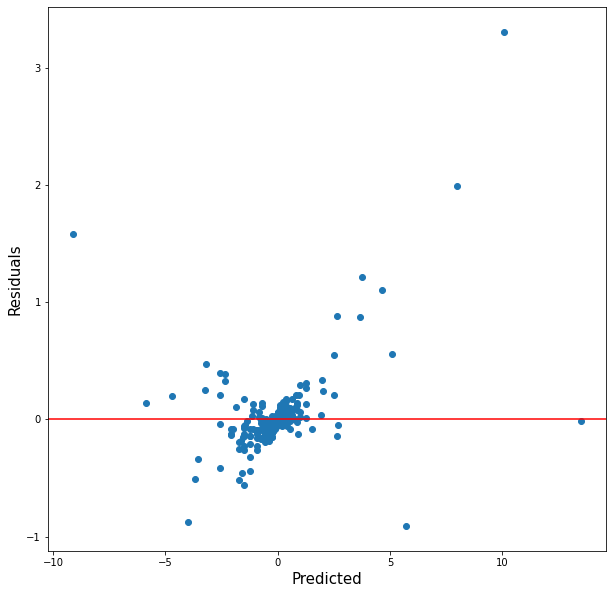

In [21]:
residuals = y_test-y_pred
plt.figure(figsize=(10,10))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.show()
# Se i punti sono scatterati attorno alla linea y=0 vuol dire che non ci sono errori sistematici (bias) nel modello

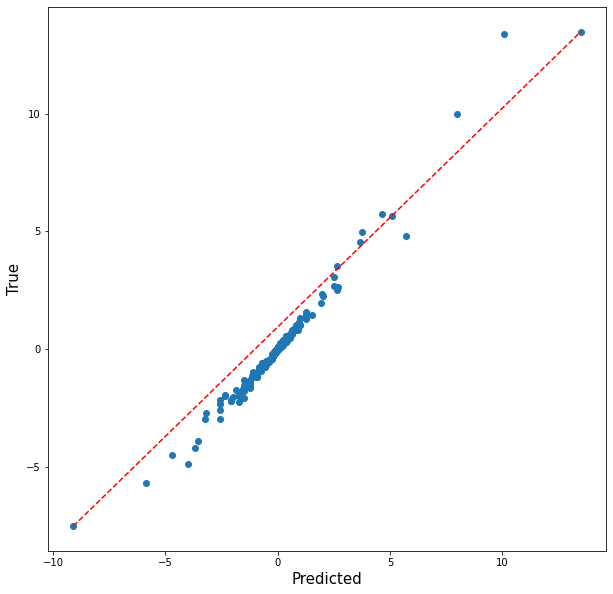

In [22]:
plt.figure(figsize=(10,10))
plt.scatter(y_pred, y_test)
plt.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("True", fontsize=15)
plt.show()
# la linea diagonale corrisponderebbe a una perfetta predizione

### Features Importance

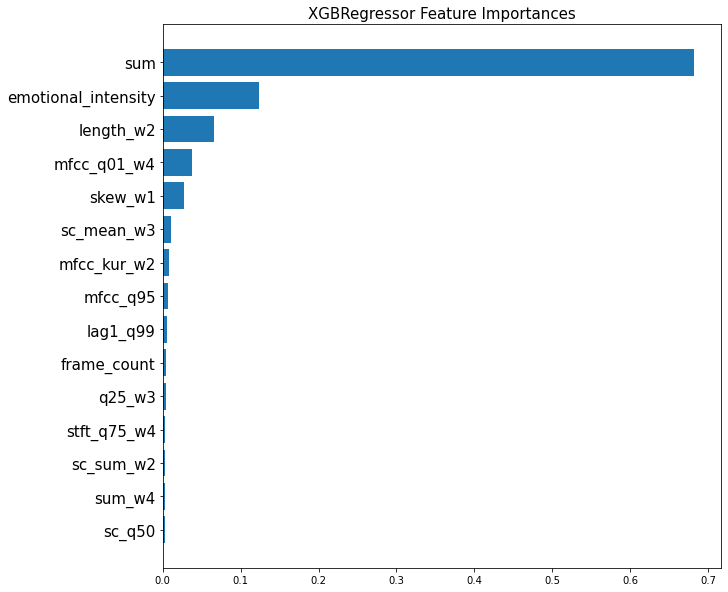

In [23]:
nbr_features = 15

tree_feature_importances = clf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots(squeeze=True, figsize=(10,10))
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(df_train.columns)[sorted_idx], fontsize=15)
plt.title("XGBRegressor Feature Importances", fontsize=15)
plt.show()

### Overfitting detection

In [24]:
results = clf.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

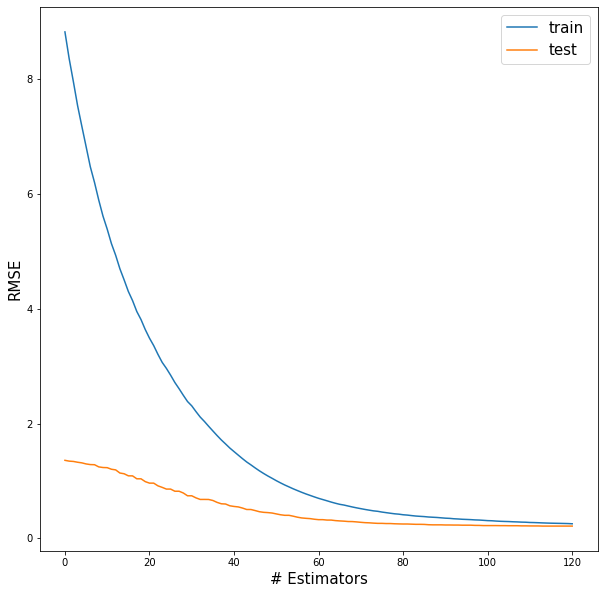

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['rmse'], label='train')
ax.plot(x_axis, results['validation_1']['rmse'], label='test')
ax.legend(fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.xlabel("# Estimators", fontsize=15)
#plt.title('XGBoost RMSE')
plt.show()

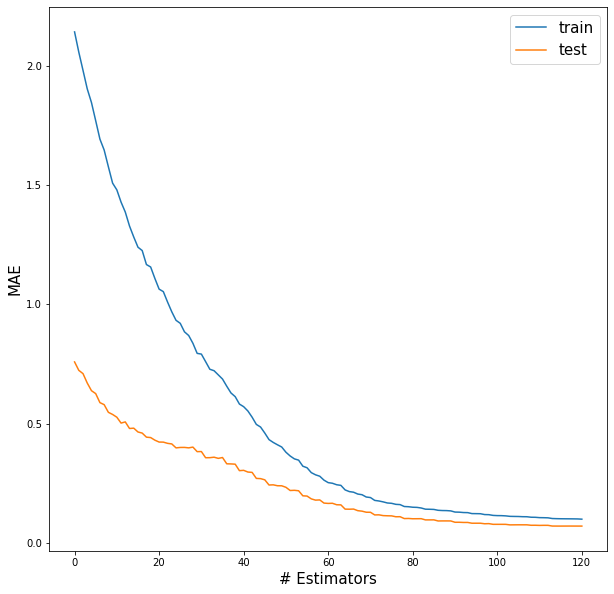

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['mae'], label='train')
ax.plot(x_axis, results['validation_1']['mae'], label='test')
ax.legend(fontsize=15)
plt.ylabel('MAE', fontsize=15)
plt.xlabel("# Estimators", fontsize=15)
#plt.title('XGBoost RMSE')
plt.show()